In [206]:
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import getdataset
import utils
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from copy import deepcopy
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import KFold
from copy import deepcopy
from demv import DEMV
from fairlearn.metrics import MetricFrame
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, GridSearch

In [207]:
def plot_confusion_matrix(y_true, y_pred, classes, datasetname,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, method = 'Biased'):
                          
    if not title:
        if normalize:
            title = 'Normalized confusion matrix: ' + str(method)
        else:
            title = 'Confusion matrix, without normalization: ' + str(method)
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    
    plt.savefig('confusionmatrices/confusion_matrix_' + str(method) + "_" + str(datasetname) + "_normalized=" +str(normalize))
    return ax

In [208]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])
classifier = pipeline

In [209]:
def getprediction(data, label, classifier, groups_condition, sensitive_features, positive_label, debiaser = 'biased'):
    fold = KFold(n_splits = 10, shuffle = True)

    expbool = False

    if(debiaser == 'demv'):
        demv = DEMV(round_level=1, debug = False, strategy='random')
        debiaser = demv
        data = debiaser.fit_transform(
            data, [keys for keys in groups_condition.keys()], label)

    if(debiaser == 'eg'):
        constr = BoundedGroupLoss(ZeroOneLoss(), upper_bound=0.1)
        exp = ExponentiatedGradient(pipeline, constr, sample_weight_name="classifier__sample_weight")
        classifier = exp

    if(debiaser == 'grid'):
        constr = BoundedGroupLoss(ZeroOneLoss(), upper_bound=0.1)
        exp = ExponentiatedGradient(pipeline, constr, sample_weight_name="classifier__sample_weight")
        grid = GridSearch(pipeline, constr, sample_weight_name="classifier__sample_weight")
        classifier = grid

    model = deepcopy(classifier)

    newdata = deepcopy(data)
    newdata['y_true'] = data[label]

    for train, test in fold.split(data):

        df_train = data.iloc[train]
        df_test = data.iloc[test]

        x_train, x_test, y_train, y_test = utils._train_test_split(df_train, df_test, label)

        model.fit(x_train, y_train, sensitive_features=df_train[sensitive_features]) if expbool else model.fit(x_train, y_train)

        pred = model.predict(x_test)

        newdata.iloc[test, newdata.columns.get_loc(label)] = pred

    return newdata
    

In [210]:
dataset = 'law'
def generatecm(dataset, debiaser = None , normalize = False):
    data, label, positive_label, sensitive_features, unpriv_group, k = getdataset.getdataset(dataset, 2)
    newdata = getprediction(data, label, classifier, unpriv_group, sensitive_features, positive_label, debiaser=debiaser )
    classes = newdata['y_true'].unique()
    plot_confusion_matrix(newdata['y_true'], newdata[label], classes, dataset, normalize = normalize)
    

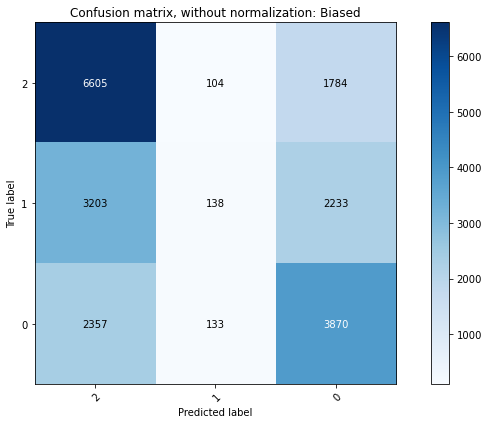

In [211]:
generatecm(dataset)